# Loan Default Classification
#### CHAPTER 11: _Bias Mitigation and Causal Inference Methods_
##### From **[Interpretable Machine Learning with Python](https://www.packtpub.com/product/interpretable-machine-learning-with-python/9781800203907)** by Serg Masís, published by Packt

## The Preparations

### Installing the Libraries

These are all already installed on Google Colab by default so install only if running elsewhere (and ***not already installed***):

In [1]:
!pip install --upgrade pandas numpy tqdm scikit-learn lightgbm xgboost networkx pydot matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 16.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 18.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 23.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 6.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 34.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 KB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 KB 30.2 MB/s eta 0:00:00
  Using cached joblib-1.3.2-py3-none-any.whl (30

Install these if running on Google Colab or ***not already installed***:

In [2]:
!pip install --upgrade machine-learning-datasets
!pip install --upgrade econml dowhy
!pip install --no-deps git+https://github.com/EthicalML/xai.git
!pip install aif360==0.3.0
!pip install BlackBoxAuditing==0.1.54

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 KB 1.8 MB/s eta 0:00:00
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 25.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 30.4 MB/s eta 0:00:00
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached idna-3.6-py3-none-any.whl (61 kB)
  Using cached charset_normalizer-3.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (142 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.3 MB/s eta 0:00:0000:0100:01
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cach

### Loading the Libraries

In [1]:
import math
import os
import warnings
warnings.filterwarnings("ignore")
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn import model_selection, tree, metrics
import lightgbm as lgb
import xgboost as xgb

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing import GerryFairClassifier
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from aif360.algorithms.postprocessing.eq_odds_postprocessing import EqOddsPostprocessing

from econml.dr import LinearDRLearner
import dowhy
from dowhy import CausalModel

import xai
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[LFR]'


### Understanding and Preparing the Data

In [2]:
ccdefault_all_df = mldatasets.load("cc-default", prepare=True)

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/cc_defaults_taiwan.csv.zip downloaded to /home/andrew/dev/uainnovate24/data/cc_defaults_taiwan.csv.zip
/home/andrew/dev/uainnovate24/data/cc_defaults_taiwan.csv.zip uncompressed to /home/andrew/dev/uainnovate24/data/cc_defaults_taiwan.csv
1 dataset files found in /home/andrew/dev/uainnovate24/data/cc_defaults_taiwan.csv folder
parsing /home/andrew/dev/uainnovate24/data/cc_defaults_taiwan.csv/cc_defaults_new_taiwan.csv


In [3]:
ccdefault_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CC_LIMIT_CAT      30000 non-null  int8   
 1   EDUCATION         30000 non-null  int8   
 2   MARITAL_STATUS    30000 non-null  int8   
 3   GENDER            30000 non-null  int8   
 4   AGE_GROUP         30000 non-null  int8   
 5   pay_status_1      30000 non-null  int8   
 6   pay_status_2      30000 non-null  int8   
 7   pay_status_3      30000 non-null  int8   
 8   pay_status_4      30000 non-null  int8   
 9   pay_status_5      30000 non-null  int8   
 10  pay_status_6      30000 non-null  int8   
 11  paid_pct_1        30000 non-null  float64
 12  paid_pct_2        30000 non-null  float64
 13  paid_pct_3        30000 non-null  float64
 14  paid_pct_4        30000 non-null  float64
 15  paid_pct_5        30000 non-null  float64
 16  paid_pct_6        30000 non-null  float6

In [4]:
ccdefault_all_df._TREATMENT.value_counts()

-1    28904
 0      274
 1      274
 2      274
 3      274
Name: _TREATMENT, dtype: int64

#### Data Preparation

In [5]:
ccdefault_bias_df = ccdefault_all_df[ccdefault_all_df._TREATMENT < 1]
ccdefault_causal_df = ccdefault_all_df[ccdefault_all_df._TREATMENT >= 0]

## Detecting Bias

### Visualizing Dataset Bias

In [6]:
ccdefault_bias_df[ccdefault_bias_df.IS_DEFAULT==1].GENDER.\
            value_counts()/ccdefault_bias_df.GENDER.value_counts()

2    0.206529
1    0.241633
Name: GENDER, dtype: float64

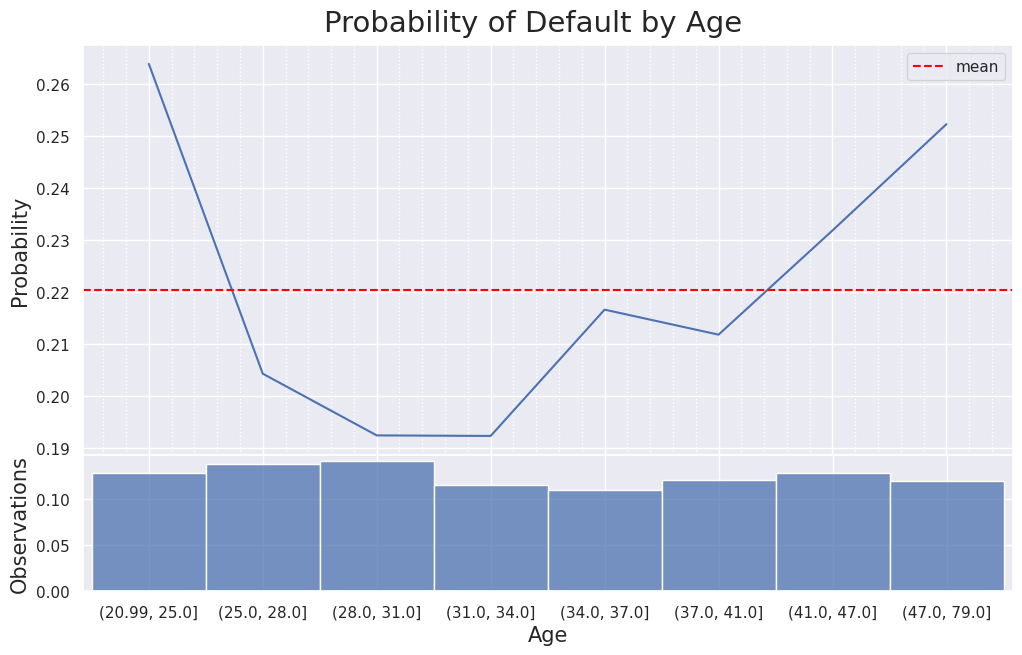

In [7]:
mldatasets.plot_prob_progression(ccdefault_bias_df._AGE, ccdefault_bias_df.IS_DEFAULT,\
                                 x_intervals=8, use_quantiles=True, xlabel='Age',\
                                 title='Probability of Default by Age', mean_line=True)

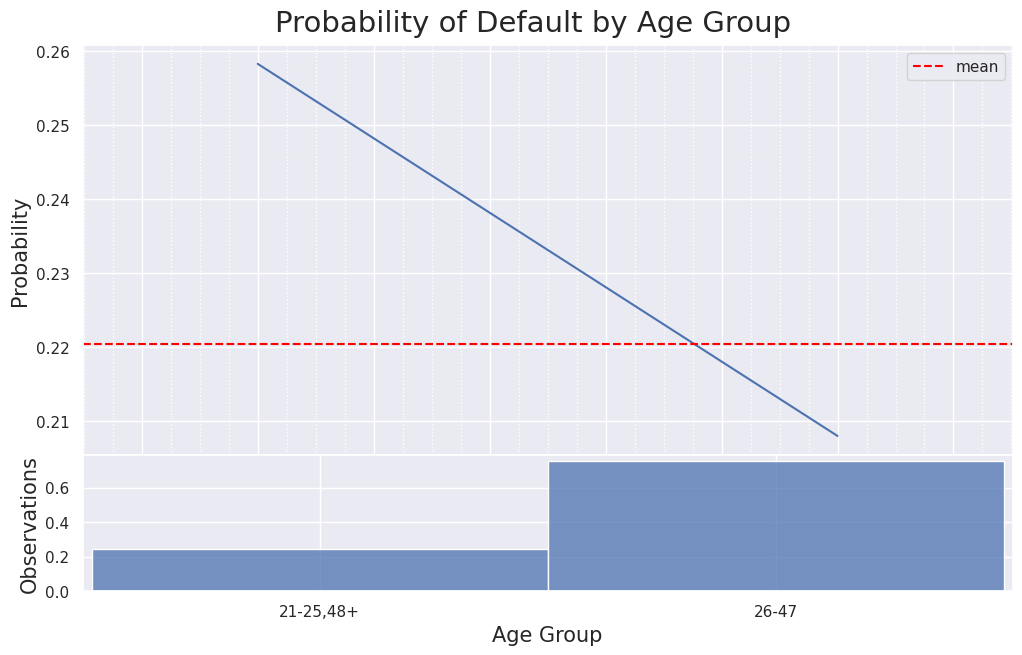

In [8]:
mldatasets.plot_prob_progression(ccdefault_bias_df.AGE_GROUP.replace({0:'21-25,48+',1:'26-47'}),\
                                 ccdefault_bias_df.IS_DEFAULT, xlabel='Age Group',\
                                 title='Probability of Default by Age Group', mean_line=True)

In [ ]:
mldatasets.plot_prob_contour_map(ccdefault_bias_df.GENDER.replace({1:'Male',2:'Female'}),\
                      ccdefault_bias_df.AGE_GROUP.replace({0:'21-25,48+',1:'26-47'}),\
                      ccdefault_bias_df.IS_DEFAULT, xlabel='Gender', ylabel='Age Group',\
                    title='Probability of Default by Gender/Age Group', plot_type='grid',\
                    annotate=True)

### Quantifying Dataset Bias

In [9]:
cols_bias_l =\
    ccdefault_all_df.columns[~ccdefault_all_df.columns.str.startswith('_')].tolist()
cols_causal_l =\
    ['AGE_GROUP','IS_DEFAULT'] +\
    ccdefault_all_df.columns[ccdefault_all_df.columns.str.startswith('_')].tolist()

ccdefault_bias_df = ccdefault_bias_df[cols_bias_l]
ccdefault_causal_df = ccdefault_causal_df[cols_causal_l]

In [10]:
rand = 9
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

y = ccdefault_bias_df['IS_DEFAULT']
X = ccdefault_bias_df.drop(['IS_DEFAULT'], axis=1).copy()
X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(X, y, test_size=0.25, random_state=rand)

In [11]:
train_ds = BinaryLabelDataset(df=X_train.join(y_train),\
                    label_names=['IS_DEFAULT'],\
                    protected_attribute_names=['AGE_GROUP', 'GENDER'],
                    favorable_label=0, unfavorable_label=1)
test_ds = BinaryLabelDataset(df=X_test.join(y_test),\
                    label_names=['IS_DEFAULT'],\
                    protected_attribute_names=['AGE_GROUP', 'GENDER'],
                    favorable_label=0, unfavorable_label=1)

In [12]:
unprivileged_groups=[{'AGE_GROUP': 0}]
privileged_groups=[{'AGE_GROUP': 1}]

metrics_train_ds = BinaryLabelDatasetMetric(train_ds,\
                            unprivileged_groups=unprivileged_groups,\
                            privileged_groups=privileged_groups)
metrics_test_ds = BinaryLabelDatasetMetric(test_ds,\
                            unprivileged_groups=unprivileged_groups,\
                            privileged_groups=privileged_groups)

print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      metrics_train_ds.statistical_parity_difference())
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      metrics_train_ds.disparate_impact())
print('Smoothed Empirical Differential Fairness (SEDF):\t%.4f' %\
      metrics_train_ds.smoothed_empirical_differential_fairness())

Statistical Parity Difference (SPD):			-0.0437
Disparate Impact (DI):					0.9447
Smoothed Empirical Differential Fairness (SEDF):	0.3514


### Quantifying Model Bias

In [13]:
cls_mdls = {}

lgb_params = {'learning_rate': 0.4, 'reg_alpha': 21, 'reg_lambda': 1,\
          'scale_pos_weight': 1.8}
lgb_base_mdl = lgb.LGBMClassifier(random_seed=rand, max_depth=6,\
                             num_leaves=33, **lgb_params)
lgb_base_mdl.fit(X_train, y_train)
cls_mdls['lgb_0_base'] = mldatasets.evaluate_class_mdl(lgb_base_mdl,X_train, X_test, y_train, y_test, plot_roc=False,plot_conf_matrix=True, save_name="mb", show_summary=True, ret_eval_dict=True)

[LightGBM] [Info] Number of positive: 4848, number of negative: 17035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 21883, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221542 -> initscore=-1.256704
[LightGBM] [Info] Start training from score -1.256704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [14]:
test_pred_ds = test_ds.copy(deepcopy=True)
test_pred_ds.labels = cls_mdls['lgb_0_base']['preds_test'].reshape(-1,1)
test_pred_ds.scores = cls_mdls['lgb_0_base']['probs_test'].reshape(-1,1)
metrics_test_dict, metrics_test_cls =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_ds,\
                          unprivileged_groups=unprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['lgb_0_base'].update(metrics_test_dict)

print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      metrics_test_cls.statistical_parity_difference())
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      metrics_test_cls.disparate_impact())
print('Average Odds Difference (AOD):\t\t\t\t%.4f' %\
      metrics_test_cls.average_odds_difference())
print('Equal Opportunity Difference (EOD):\t\t\t%.4f' %\
      metrics_test_cls.equal_opportunity_difference())
print('Differential Fairness Bias Amplification (DFBA):\t%.4f' %\
      metrics_test_cls.differential_fairness_bias_amplification())

Statistical Parity Difference (SPD):			-0.0679
Disparate Impact (DI):					0.9193
Average Odds Difference (AOD):				-0.0550
Equal Opportunity Difference (EOD):			-0.0265
Differential Fairness Bias Amplification (DFBA):	0.2328


## Mitigating Bias

### Pre-processing Bias Mitigation Methods

#### Reweighting Method

In [17]:
reweighter = Reweighing(unprivileged_groups=unprivileged_groups,\
                        privileged_groups=privileged_groups)
reweighter.fit(train_ds)
train_rw_ds = reweighter.transform(train_ds)

In [18]:
metrics_train_rw_ds = BinaryLabelDatasetMetric(train_rw_ds,\
                            unprivileged_groups=unprivileged_groups,\
                            privileged_groups=privileged_groups)

print('Statistical Parity Difference (SPD):\t\t\t%.4f' %\
      metrics_train_rw_ds.statistical_parity_difference())
print('Disparate Impact (DI):\t\t\t\t\t%.4f' %\
      metrics_train_rw_ds.disparate_impact())
print('Smoothed Empirical Differential Fairness (SEDF):\t%.4f' %\
      metrics_train_rw_ds.smoothed_empirical_differential_fairness())

Statistical Parity Difference (SPD):			-0.0000
Disparate Impact (DI):					1.0000
Smoothed Empirical Differential Fairness (SEDF):	0.1942


In [19]:
np.abs(train_ds.instance_weights.mean() - train_rw_ds.instance_weights.mean()) < 1e-6

True

In [20]:
lgb_rw_mdl = lgb.LGBMClassifier(random_seed=rand, max_depth=6,\
                             num_leaves=33, **lgb_params)
lgb_rw_mdl.fit(X_train, y_train,
              sample_weight=train_rw_ds.instance_weights)

LGBMClassifier(learning_rate=0.4, max_depth=6, num_leaves=33, random_seed=9,
               reg_alpha=21, reg_lambda=1, scale_pos_weight=1.8)

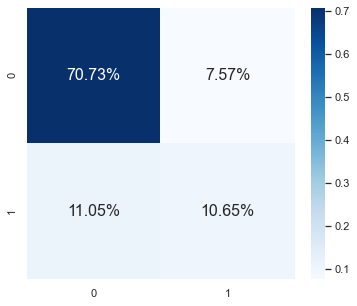

Accuracy_train:  0.8240		Accuracy_test:   0.8138
Precision_test:  0.5847		Recall_test:     0.4908
ROC-AUC_test:    0.7886		F1_test:         0.5337		MCC_test: 0.4210


In [21]:
cls_mdls['lgb_1_rw'] =\
    mldatasets.evaluate_class_mdl(lgb_rw_mdl,\
            train_rw_ds.features, X_test, train_rw_ds.labels, y_test,\
            plot_roc=False, plot_conf_matrix=True, show_summary=True,\
            ret_eval_dict=True)

test_pred_rw_ds = test_ds.copy(deepcopy=True)
test_pred_rw_ds.labels = cls_mdls['lgb_1_rw']['preds_test'].reshape(-1,1)
test_pred_rw_ds.scores = cls_mdls['lgb_1_rw']['probs_test'].reshape(-1,1)
metrics_test_rw_dict, _ =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_rw_ds,\
                          unprivileged_groups=unprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['lgb_1_rw'].update(metrics_test_rw_dict)

#### Disparate Impact Remover Method

In [22]:
protected_index = train_ds.feature_names.index('AGE_GROUP')

In [23]:
di = np.array([])
train_dir_ds = None
test_dir_ds = None
lgb_dir_mdl = None
X_train_dir = None
X_test_dir = None

levels = np.hstack([np.linspace(0., 0.1, 41), np.linspace(0.2, 1, 9)])

for level in tqdm(levels):
    di_remover = DisparateImpactRemover(repair_level=level)
    train_dir_ds_i = di_remover.fit_transform(train_ds)
    test_dir_ds_i = di_remover.fit_transform(test_ds)
    
    X_train_dir_i = np.delete(train_dir_ds_i.features, protected_index, axis=1)
    X_test_dir_i = np.delete(test_dir_ds_i.features, protected_index, axis=1)
    
    lgb_dir_mdl_i = lgb.LGBMClassifier(random_seed=rand, max_depth=5,\
                             num_leaves=33, **lgb_params)
    lgb_dir_mdl_i.fit(X_train_dir_i, train_dir_ds_i.labels)
    
    test_dir_ds_pred_i = test_dir_ds_i.copy()
    test_dir_ds_pred_i.labels = lgb_dir_mdl_i.predict(X_test_dir_i)
    metrics_test_dir_ds = BinaryLabelDatasetMetric(test_dir_ds_pred_i,\
                                   unprivileged_groups=unprivileged_groups,\
                                   privileged_groups=privileged_groups)
    di_i = metrics_test_dir_ds.disparate_impact()
    
    if (di.shape[0]==0) or (np.min(np.abs(di-1)) >= abs(di_i-1)):
        print(abs(di_i-1))
        train_dir_ds = train_dir_ds_i
        test_dir_ds = test_dir_ds_i
        X_train_dir = X_train_dir_i
        X_test_dir = X_test_dir_i
        lgb_dir_mdl = lgb_dir_mdl_i
        
    di = np.append(np.array(di), di_i)

0.0848151190044345
0.07846267133852836
0.0755038831411462
0.07481081731642347



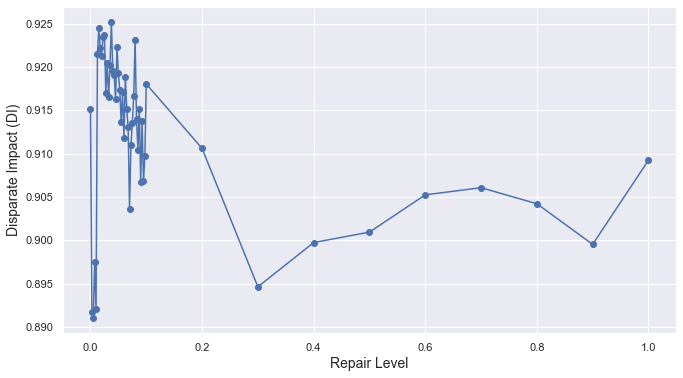

In [24]:
sns.set()
plt.figure(figsize=(11,6))
plt.plot(levels, di, marker='o')
plt.ylabel('Disparate Impact (DI)', fontsize=14)
plt.xlabel('Repair Level', fontsize=14)
#plt.xscale('log')
plt.show()

In [25]:
cls_mdls['lgb_1_dir'] =\
    mldatasets.evaluate_class_mdl(lgb_dir_mdl,\
            X_train_dir, X_test_dir, train_dir_ds.labels, test_dir_ds.labels,\
            plot_roc=False, plot_conf_matrix=False, show_summary=False,\
            ret_eval_dict=True)

test_pred_dir_ds = test_ds.copy(deepcopy=True)
test_pred_dir_ds.labels = cls_mdls['lgb_1_dir']['preds_test'].reshape(-1,1)
metrics_test_dir_dict, _ =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_dir_ds,\
                          unprivileged_groups=unprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['lgb_1_dir'].update(metrics_test_dir_dict)

### In-processing Bias Mitigation Methods

#### Prejudice Remover Method

In [26]:
log_pr_mdl = PrejudiceRemover(eta=1.0, sensitive_attr='AGE_GROUP', class_attr='IS_DEFAULT')
log_pr_mdl.fit(train_ds)

In [27]:
train_pred_pr_ds = log_pr_mdl.predict(train_ds)
test_pred_pr_ds = log_pr_mdl.predict(test_ds)

cls_mdls['log_2_pr'] =\
    mldatasets.evaluate_class_metrics_mdl(log_pr_mdl, train_pred_pr_ds.labels,\
                test_pred_pr_ds.scores, test_pred_pr_ds.labels, y_train, y_test)
metrics_test_pr_dict, _ =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_pr_ds,\
                          unprivileged_groups=unprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['log_2_pr'].update(metrics_test_pr_dict)

#### GerryFair Classifier Method

In [193]:
dt_gf_mdl = GerryFairClassifier(C=100, gamma=.005, fairness_def='FN',\
                                max_iters=50, printflag=True,\
                                predictor=tree.DecisionTreeRegressor(max_depth=3))

dt_gf_mdl.fit(train_ds, early_termination=True)

iteration: 1, error: 0.17863181465064204, fairness violation: 0.00248572931140393, violated group size: 0.1340309829548051
iteration: 2, error: 0.17863181465064204, fairness violation: 0.00248572931140393, violated group size: 0.1340309829548051
iteration: 3, error: 0.17863181465064204, fairness violation: 0.00248572931140393, violated group size: 0.1340309829548051
iteration: 4, error: 0.17863181465064204, fairness violation: 0.00248572931140393, violated group size: 0.1340309829548051
iteration: 5, error: 0.17863181465064204, fairness violation: 0.00248572931140393, violated group size: 0.1340309829548051


In [190]:
train_pred_gf_ds = dt_gf_mdl.predict(train_ds, threshold=False)
test_pred_gf_ds = dt_gf_mdl.predict(test_ds, threshold=False)
cls_mdls['dt_2_gf'] =\
    mldatasets.evaluate_class_metrics_mdl(dt_gf_mdl, train_pred_gf_ds.labels,\
                                None, test_pred_gf_ds.labels, y_train, y_test)
metrics_test_gf_dict, _ =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_gf_ds,\
                          unprivileged_groups=unprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['dt_2_gf'].update(metrics_test_gf_dict)

### Post-processing Bias Mitigation Methods

#### Equalized Odds Postprocessing Method

In [30]:
epp = EqOddsPostprocessing(privileged_groups=privileged_groups,\
                           unprivileged_groups=unprivileged_groups,\
                           seed=rand)
epp = epp.fit(test_ds, test_pred_ds)
test_pred_epp_ds = epp.predict(test_pred_ds)

In [31]:
cls_mdls['lgb_3_epp'] =\
    mldatasets.evaluate_class_metrics_mdl(lgb_base_mdl, cls_mdls['lgb_0_base']['preds_train'],\
                            test_pred_epp_ds.scores, test_pred_epp_ds.labels, y_train, y_test)
metrics_test_epp_dict, _ =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_epp_ds,\
                          unprivileged_groups=unprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['lgb_3_epp'].update(metrics_test_epp_dict)

#### Calibrated Equalized Odds Postprocessing Method

In [32]:
cpp = CalibratedEqOddsPostprocessing(privileged_groups=privileged_groups,\
                                     unprivileged_groups=unprivileged_groups,\
                                     cost_constraint="fpr",
                                     seed=rand)
cpp = cpp.fit(test_ds, test_pred_ds)
test_pred_cpp_ds = cpp.predict(test_pred_ds)

cls_mdls['lgb_3_cpp'] =\
    mldatasets.evaluate_class_metrics_mdl(lgb_base_mdl, cls_mdls['lgb_0_base']['preds_train'],\
                            test_pred_cpp_ds.scores, test_pred_cpp_ds.labels, y_train, y_test)
metrics_test_cpp_dict, _ =\
        mldatasets.compute_aif_metrics(test_ds, test_pred_cpp_ds,\
                          unprivileged_groups=unprivileged_groups,\
                          privileged_groups=privileged_groups)
cls_mdls['lgb_3_cpp'].update(metrics_test_cpp_dict)

### Tying It All Together!

In [191]:
cls_metrics_df = pd.DataFrame.from_dict(cls_mdls, 'index')\
                    [['accuracy_train', 'accuracy_test', 'f1_test', 'mcc_test',\
                      'SPD', 'DI', 'AOD', 'EOD', 'DFBA']]
with pd.option_context('display.precision', 4):
    html = cls_metrics_df.sort_values(by='accuracy_test', ascending=False).style.\
        background_gradient(cmap='plasma_r', low=0.3, high=1, subset=['SPD', 'AOD', 'EOD']).\
        background_gradient(cmap='viridis_r', low=1, high=0.3, subset=['DI', 'DFBA'])
html

,accuracy_train,accuracy_test,f1_test,mcc_test,SPD,DI,AOD,EOD,DFBA
dt_2_gf,0.8214,0.8262,0.4812,0.4135,-0.0548,0.9388,-0.0430,-0.0216,0.2521
lgb_0_base,0.8255,0.8167,0.5330,0.4243,-0.0679,0.9193,-0.0550,-0.0265,0.2328
lgb_1_rw,0.8240,0.8138,0.5337,0.4210,-0.0371,0.9552,-0.0171,-0.0018,0.0349
lgb_1_dir,0.8237,0.8129,0.5301,0.4171,-0.0624,0.9252,-0.0493,-0.0214,0.2545
lgb_3_epp,0.8255,0.8101,0.5152,0.4025,-0.0260,0.9688,0.0022,-0.0021,0.0031
lgb_3_cpp,0.8255,0.2622,0.2129,-0.3055,-0.0711,0.7609,-0.0635,-0.1262,0.0432
log_2_pr,0.1912,0.1873,0.2844,-0.3363,0.0520,1.7627,0.0498,0.0235,0.3454


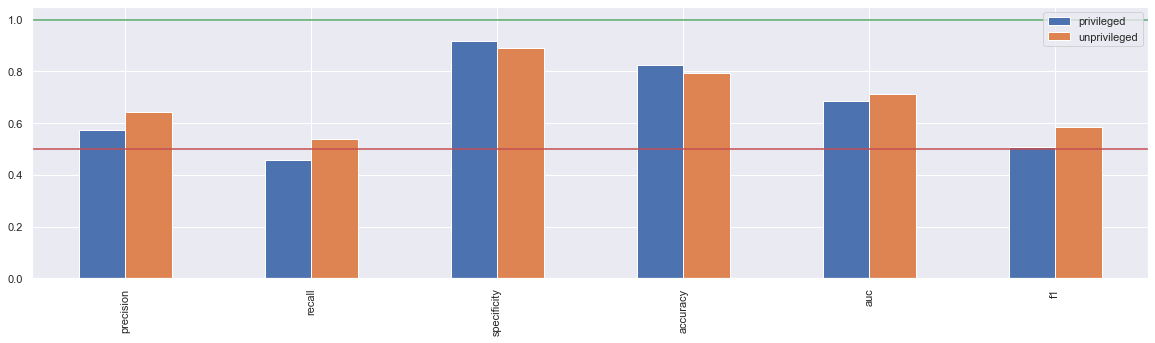

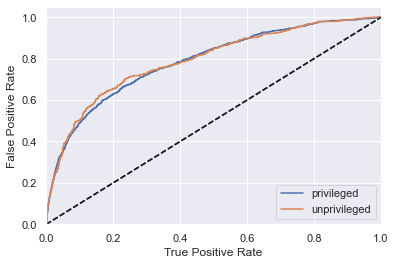

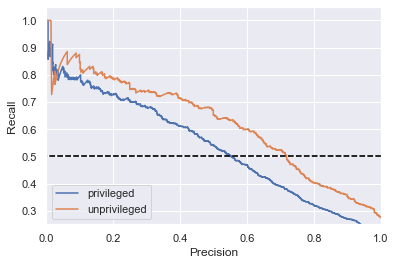

In [36]:
test_df = ccdefault_bias_df.loc[X_test.index]
test_df['AGE_GROUP'] =\
    test_df.AGE_GROUP.replace({0:'unprivileged', 1:'privileged'})
cat_cols_l = ccdefault_bias_df.dtypes[lambda x: x==np.int8].index.tolist()

_ = xai.metrics_plot(
        y_test, cls_mdls['lgb_3_epp']['probs_test'],\
        df=test_df, cross_cols=['AGE_GROUP'],\
        categorical_cols=cat_cols_l)
_ = xai.roc_plot(
        y_test, cls_mdls['lgb_3_epp']['probs_test'],\
        df=test_df, cross_cols=['AGE_GROUP'],\
        categorical_cols=cat_cols_l)
_ = xai.pr_plot(
        y_test, cls_mdls['lgb_3_epp']['probs_test'],\
        df=test_df, cross_cols=['AGE_GROUP'],\
        categorical_cols=cat_cols_l)

## Creating a Causal Model

In [37]:
treatment_names = ['Lower Credit Limit', 'Payment Plan', 'Payment Plan &\nLower Credit Limit']
all_treatment_names = np.array(["None"] + treatment_names)

### Understanding the Results of the Experiment

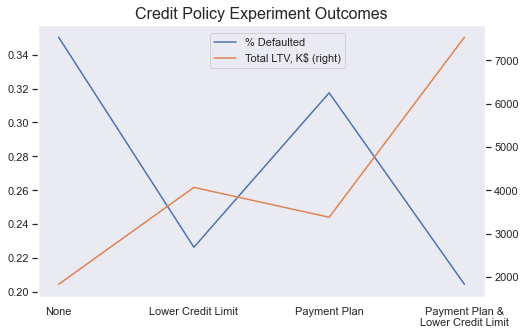

In [38]:
pct_s = ccdefault_causal_df[ccdefault_causal_df.IS_DEFAULT==1].\
                groupby(['_TREATMENT']).size() /\
         ccdefault_causal_df.groupby(['_TREATMENT']).size()
ltv_s = ccdefault_causal_df.groupby(['_TREATMENT'])\
                                            ['_LTV'].sum()/1000
plot_df = pd.DataFrame({'% Defaulted':pct_s, 'Total LTV, K$':ltv_s})
plot_df.index = all_treatment_names

ax = plot_df.plot(secondary_y=['Total LTV, K$'], figsize=(8,5))
ax.get_legend().set_bbox_to_anchor((0.7, 0.99))
plt.grid(False)
plt.title("Credit Policy Experiment Outcomes", fontsize=16)
plt.show()

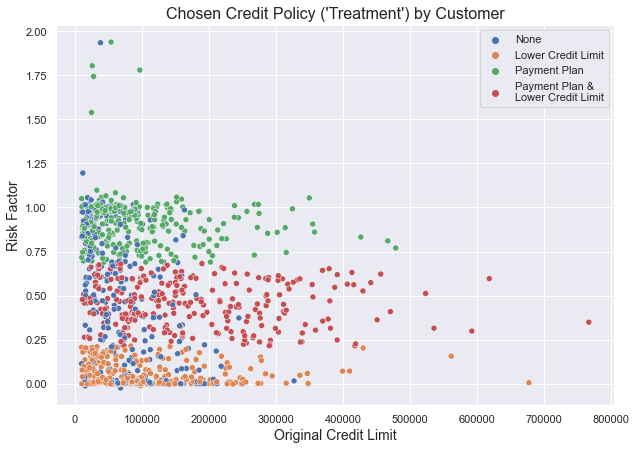

In [39]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=ccdefault_causal_df['_CC_LIMIT'].values,
    y=ccdefault_causal_df['_risk_score'].values,
    hue=all_treatment_names[ccdefault_causal_df['_TREATMENT'].values],
    hue_order=all_treatment_names
)
plt.title("Chosen Credit Policy ('Treatment') by Customer", fontsize=16)
plt.xlabel("Original Credit Limit", fontsize=14)
plt.ylabel("Risk Factor", fontsize=14)
plt.show()

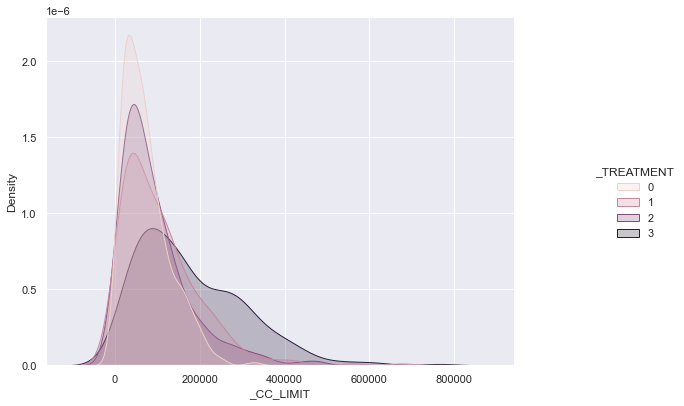

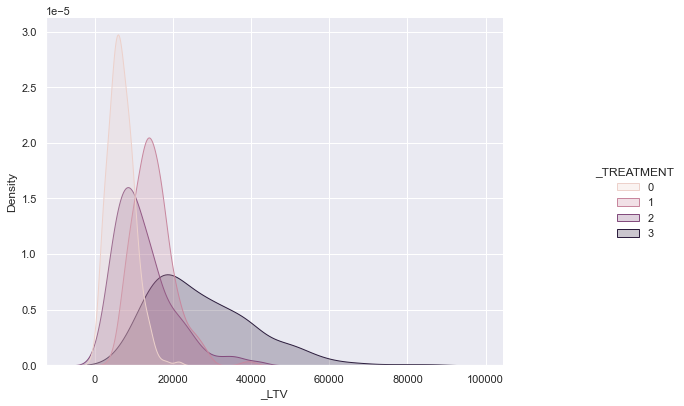

In [40]:
ax = sns.displot(ccdefault_causal_df, x="_CC_LIMIT", hue="_TREATMENT", kind="kde", fill=True)
ax.fig.set_figheight(6)
ax.fig.set_figwidth(10)
ax = sns.displot(ccdefault_causal_df, x="_LTV", hue="_TREATMENT", kind="kde", fill=True)
ax.fig.set_figheight(6)
ax.fig.set_figwidth(10)

### Understanding Causal Models

In [41]:
W = ccdefault_causal_df[['_spend','_tpm','_ppm','_RETAIL','_URBAN','_RURAL','_PREMIUM']]
X = ccdefault_causal_df[['_CC_LIMIT']]
T = ccdefault_causal_df[['_TREATMENT']]
Y = ccdefault_causal_df[['_LTV']]

In [68]:
reg_mdl = xgb.XGBRegressor().fit(W.join(X), Y)
reg_preds = reg_mdl.predict(W.join(X))
print(metrics.mean_squared_error(Y, reg_preds, squared=False))

821.9857550780735


In [69]:
cls_mdl = xgb.XGBClassifier(objective="multi:softmax").fit(W.join(X), T)
cls_preds = cls_mdl.predict(W.join(X))
print(metrics.accuracy_score(T, cls_preds))

[18:18:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1.0


### Initializing the Linear Doubly Robust Learner

In [155]:
drlearner = LinearDRLearner(
                model_regression=xgb.XGBRegressor(learning_rate=0.1),
                model_propensity=xgb.XGBClassifier(learning_rate=0.1, max_depth=2, objective="multi:softmax"),
                random_state=rand,
)

### Fitting the Causal Model

In [156]:
causal_mdl = drlearner.dowhy.fit(Y, T, X=X, W=W, 
                            outcome_names=Y.columns.to_list(), 
                            treatment_names=T.columns.to_list(),
                            feature_names=X.columns.to_list(),
                            confounder_names=W.columns.to_list(), 
                            target_units=X.iloc[:550].values)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['_TREATMENT'] on outcome ['_LTV']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~_TREATMENT+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[17:05:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:05:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_graph:Using Matplotlib for plotting


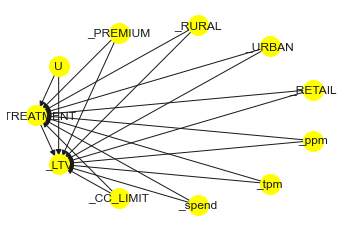

In [52]:
try:
    display(
        Image(to_pydot(causal_mdl._graph._graph).create_png())
    )
    #to_pydot(causal_mdl._graph._graph).write('causal_model.dot')
except:
    causal_mdl.view_model()

## Understanding Heterogeneous Treatment Effects

In [157]:
identified_ate = causal_mdl.identified_estimand_
print(identified_ate)
drlearner_estimate = causal_mdl.estimate_
print(drlearner_estimate)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
      d                                                                       
─────────────(Expectation(_LTV|_URBAN,_ppm,_CC_LIMIT,_tpm,_spend,_RETAIL,_PREM
d[_TREATMENT]                                                                 

            
IUM,_RURAL))
            
Estimand assumption 1, Unconfoundedness: If U→{_TREATMENT} and U→_LTV then P(_LTV|_TREATMENT,_URBAN,_ppm,_CC_LIMIT,_tpm,_spend,_RETAIL,_PREMIUM,_RURAL,U) = P(_LTV|_TREATMENT,_URBAN,_ppm,_CC_LIMIT,_tpm,_spend,_RETAIL,_PREMIUM,_RURAL)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: _LTV~_TREATMENT+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT
Target units: 

## Estimate
Mean value: 7221.414390341943
Effec

In [158]:
for i in range(causal_mdl._d_t[0]):
    print("Treatment: %s" % treatment_names[i])
    display(causal_mdl.summary(T=i+1))
    print("\r\n")

Treatment: Lower Credit Limit


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,0.032,0.031,1.03,0.303,-0.019,0.082
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,5525.069,1941.489,2.846,0.004,2331.604,8718.533




Treatment: Payment Plan


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,0.073,0.031,2.396,0.017,0.023,0.124
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-481.22,1965.691,-0.245,0.807,-3714.494,2752.054




Treatment: Payment Plan &
Lower Credit Limit


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,0.095,0.03,3.171,0.002,0.046,0.145
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,4238.783,1907.747,2.222,0.026,1100.818,7376.748


In [161]:
idxs = np.arange(0, causal_mdl._d_t[0])
coefs = np.hstack([causal_mdl.coef_(T=i+1) for i in idxs])
intercepts = np.hstack([causal_mdl.intercept_(T=i+1) for i in idxs])

coefs_err = np.hstack([causal_mdl.coef__interval(T=i+1) for i in idxs])
coefs_err[0, :] = coefs - coefs_err[0, :]
coefs_err[1, :] = coefs_err[1, :] - coefs

intercepts_err = np.vstack(
    [causal_mdl.intercept__interval(T=i+1) for i in idxs]
).T
intercepts_err[0, :] = intercepts - intercepts_err[0, :]
intercepts_err[1, :] = intercepts_err[1, :] - intercepts

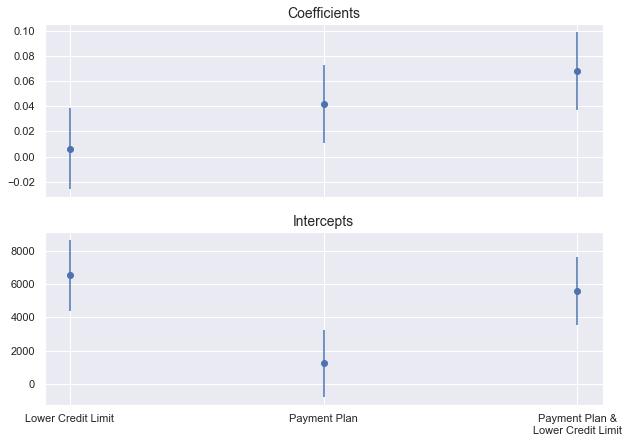

In [162]:
plt.figure(figsize=(10, 7))
ax1 = plt.subplot(2, 1, 1)
plt.errorbar(idxs, coefs, coefs_err, fmt="o")
plt.xticks(idxs, treatment_names)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.title("Coefficients", fontsize=14)

plt.subplot(2, 1, 2)
plt.errorbar(idxs, intercepts, intercepts_err, fmt="o")
plt.xticks(idxs, treatment_names)
plt.title("Intercepts", fontsize=14)
plt.show()

### Choosing Policies

In [180]:
cost_fn = lambda X: np.repeat(np.array([[0, 1000, 1000]]), X.shape[0], axis=0) +\
                    (np.repeat(np.array([[72, 0, 72]]), X.shape[0], axis=0) *\
                     X._ppm.values.reshape(-1,1))

treatment_effect_minus_costs = causal_mdl.const_marginal_effect(X=X.values) -\
                                    cost_fn(ccdefault_causal_df)
treatment_effect_minus_costs = np.hstack([np.zeros(X.shape), treatment_effect_minus_costs])
recommended_T = np.argmax(treatment_effect_minus_costs, axis=1)

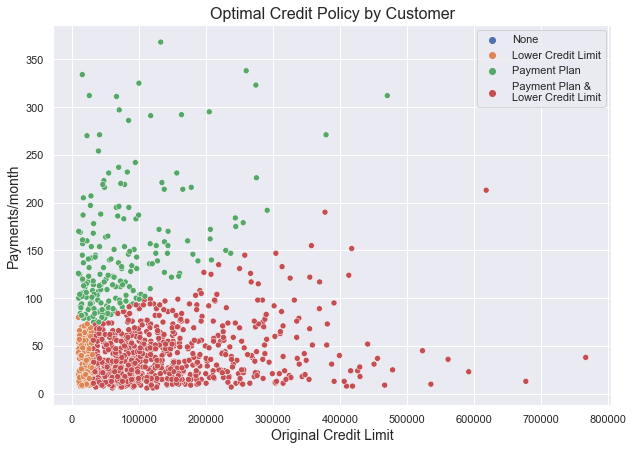

In [181]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=ccdefault_causal_df['_CC_LIMIT'].values,
    y=ccdefault_causal_df["_ppm"].values,
    hue=all_treatment_names[recommended_T],
    hue_order=all_treatment_names
)
plt.title("Optimal Credit Policy by Customer", fontsize=16)
plt.xlabel("Original Credit Limit", fontsize=14)
plt.ylabel("Payments/month", fontsize=14)
plt.show()

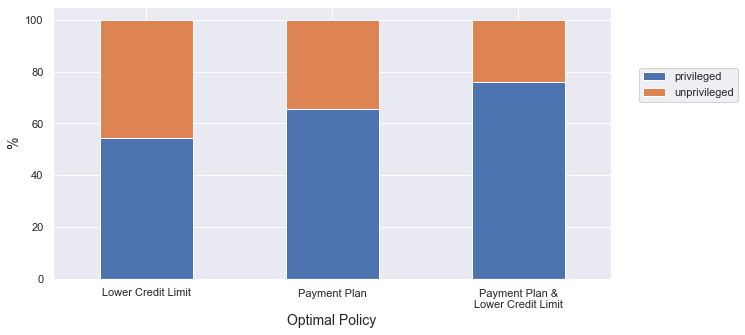

In [165]:
ccdefault_causal_df['recommended_T'] = recommended_T
plot_df = ccdefault_causal_df.groupby(['recommended_T','AGE_GROUP']).\
                                                    size().reset_index()
plot_df['AGE_GROUP'] = plot_df.AGE_GROUP.replace({0:'unprivileged', 1:'privileged'})
plot_df = plot_df.pivot(columns='AGE_GROUP', index='recommended_T', values=0)
plot_df.index = treatment_names
plot_df = plot_df.apply(lambda r: r/r.sum()*100, axis=1)

plot_df.plot.bar(stacked=True, rot=0, figsize=(10,5))
plt.legend(loc=(1.05, 0.65))
plt.xlabel('Optimal Policy', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.show()

## Testing Estimate Robustness

### Adding Random Common Cause

In [184]:
ref_random = causal_mdl.refute_estimate(method_name="random_common_cause")
print(ref_random)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~_TREATMENT+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL+w_random | _CC_LIMIT


[22:48:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:48:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Refute: Add a Random Common Cause
Estimated effect:7221.414390341943
New effect:7546.695920181393



### Replacing Treatment with a Random Variable

In [183]:
ref_placebo = causal_mdl.refute_estimate(\
                    method_name="placebo_treatment_refuter",\
                    placebo_type="permute", num_simulations=20)
print(ref_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 20 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator


[22:10:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator


[22:10:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: _LTV~placebo+_URBAN+_ppm+_CC_LIMIT+_tpm+_spend+_RETAIL+_PREMIUM+_RURAL | _CC_LIMIT


[22:10:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


Refute: Use a Placebo Treatment
Estimated effect:7221.414390341943
New effect:132.77295305233164
p value:0.43187234564256083

